<a href="https://colab.research.google.com/github/StratosFair/Mean_Escape_Time/blob/main/OU_process_2D/Models/boundary_adapted%5BWIP%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Imports & FP64
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

# Solving for the MET of an Ornstein-Uhlenbeck process in a disk with "Adapted Architecture PINNs" : comparison with exact solution

## 1) Setup

For $\theta,\sigma,r >0$ some fixed parameters, we let $\Omega := B_r \equiv \{x\in\mathbb R^d : \|x\|< r \}$, and define the process ($d=2$ in our illustration) :

$$\begin{cases} dX_t &= -\theta X_t dt + \sigma dB_t \\
X_0 &= x \in \Omega \end{cases} $$

For all $x\in\Omega$, let

$$T(x) := \inf\{t\ge 0 : X_t \in\partial\Omega\} $$

and let its first moment be denoted

$$\tau(x) := \mathbb E[T(x)] $$

We can show under some regularity conditions on $\Omega$ that $\tau$ is the (unique) solution of the BVP :

$$\begin{cases} -\mathcal{L}u(x) &= 1 \text{ for all } x\in\Omega \\
u(x) &= 0 \text{ for all } x\in\partial\Omega \end{cases} $$

where $\mathcal L$ is the infinitesimal generator of the Ornstein-Uhlenbeck process, given by
$$\mathcal Lu : x \mapsto -\theta x \cdot \nabla u(x) + \frac{\sigma^2}{2}\Delta u(x) $$

Nicely enough, for this problem, we can compare our solution with the known closed-form solution (see https://arxiv.org/abs/2208.04029) :

$$ \tau(x) := \frac{1}{\lambda^{d/2}\sigma^2}\int_\rho^r z^{1-d} e^{\lambda z^2} \gamma(d/2, \lambda z^2)\ dz $$

where $\lambda := \theta/\sigma^2 $, $\rho := \|x\| $ and $\gamma$ is the upper incomplete gamma function :
$$\gamma(n,y) := \int_0^y t^{n-1} e^{-t}\ dt.  $$

In [10]:
# Problem Parameters & True Solution
R = 2.0
theta = 1.0
sigma = 1.0

def true_tau(x, y, theta=theta, sigma=sigma, R=R):
    lam = theta / sigma**2
    rho = np.sqrt(x**2 + y**2)
    integrand = lambda t: np.exp(lam * t**2) * special.gammainc(1, lam * t**2) / t
    I, _ = integrate.quad(integrand, rho, R)
    return I / theta

true_tau_vec = np.vectorize(true_tau)

## 2) Neural Network architecture and loss function

Unlike the standard PINN, we will take an hypothesis space of Neural Networks which satisfy the boundary conditions explicitly. For this problem, we have homogenous zero Dirichlet boundary conditions, which we can enforce by multiplying our Neural Networks with an appropriate "smooth distance approximation" (see https://arxiv.org/abs/2104.08426). In accordance with the mentioned paper, we will take
$$\varphi : x\mapsto \frac{R^2 - \|x\|^2}{2R}$$
as our smooth distance approximation.  


With this modification, our objective to minimize becomes
$$\hat u := \arg\min_{u\in\mathcal{NN}_\varphi}\ \frac1n \sum_{i=1}^n (\mathcal L u(x_i^c) + 1)^2 $$
where $x_i^c$ are sampled i.i.d. with uniform distribution on $\Omega$,
$$\mathcal{NN}_\varphi:=\left\{x\mapsto \varphi(x) \cdot T_L\circ \sigma \circ T_{L-1}\circ\cdots\circ \sigma\circ T_1 (x)\right\}, $$
for
$$T_\ell : \mathbb{R}^{\ell-1}\to\mathbb{R}^\ell $$
affine-linear maps of appropriate input-output dimensions, where
$$\sigma :x \mapsto \begin{cases}x^2 &\text{ if } x\ge 0\\ 0 &\text{ if } x\le 0\end{cases} \quad \text{OR }\ \ \sigma : x\mapsto \operatorname{tanh}(x),$$
is either the ReQU or hyperbolic tangent activation function, which is understood element-wise when applied to vectors.

In [11]:
# defining PINN w/ matching boundary condition
power = None #exponent k for relu^k, none for tanh
width = 50
depth = 3
gain = 1.0 #magnitude of weights at initialization

#define ReLU^k activation

class RePU(nn.Module):
    def __init__(self, power = power):
        super(RePU, self).__init__()
        self.power = power

    def forward(self, x):
        return torch.pow(torch.relu(x), self.power)

#define the smooth distance approximation
def smooth_distance(x, exponent):
    norm_x = torch.linalg.norm(x, dim=-1)
    dist =  (R**2 - norm_x**2)/(2*R)
    return dist**exponent

#define hypothesis space
class BoundaryPINN(nn.Module):
    def __init__(self, power = power, width = width, depth = depth):
        super(BoundaryPINN,self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, width))
        if isinstance(power, int):
            self.layers.append(RePU(power))
            for _ in range(depth-1) :
                self.layers.append(nn.Linear(width, width))
                self.layers.append(RePU(power))
        else :
            self.layers.append(nn.Tanh())
            for _ in range(depth-1) :
                self.layers.append(nn.Linear(width, width))
                self.layers.append(nn.Tanh())
        self.layers.append(nn.Linear(width, 1))
        self.mlp = nn.Sequential(*self.layers)

        #for the exponent in the distance function
        self.exponent = nn.Parameter(torch.tensor(1.0, dtype= torch.float64))

        #for dynamic weighting, first biased towards data fidelity
        self.log_sigma_pde = nn.Parameter(torch.tensor(0.0,\
                                                        dtype=torch.float64))
        self.log_sigma_sobolev = nn.Parameter(torch.tensor(np.log(10),\
                                                        dtype=torch.float64))

    def forward(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        distance =  smooth_distance(x, self.exponent)
        return output * distance.unsqueeze(-1)

    def raw_forward(self, x):
        #returns the raw neural network output without multiplication by
        #distance to boundary
        return self.mlp(x)

#weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight, gain=gain)
        m.bias.data.fill_(gain)

In [12]:
# defining PDE Residual & Loss, enabling grad on x
def pde_residual(model, x, theta, sigma, forcing = None):
    # ensure x is on the right device, float64, and requires grad
    x = x.clone().detach().to(device).requires_grad_(True)

    # forward through PINN
    tau = model(x)                                # [N]
    # first derivatives
    grads = torch.autograd.grad(
        tau, x,
        grad_outputs=torch.ones_like(tau),
        create_graph=True,
    )[0]                                        # [N,2]
    tau_x, tau_y = grads[:,0], grads[:,1]

    # second derivatives
    tau_xx = torch.autograd.grad(
        tau_x, x,
        grad_outputs=torch.ones_like(tau_x),
        create_graph=True
    )[0][:,0]
    tau_yy = torch.autograd.grad(
        tau_y, x,
        grad_outputs=torch.ones_like(tau_y),
        create_graph=True
    )[0][:,1]

    # OU‐generator L[tau]
    phys = -theta*(x[:,0]*tau_x + x[:,1]*tau_y) \
           + 0.5*sigma**2*(tau_xx + tau_yy)

    if forcing is None:
        # default constant −1
        f_vals = -1.0
    elif isinstance(forcing, (int, float)):
        # constant forcing = that number
        f_vals = float(forcing)
    elif callable(forcing):
        # call it on x
        f_vals = forcing(x)
        # flatten to [N]
        if f_vals.dim() > 1:
            f_vals = f_vals.view(-1)
    else:
        raise ValueError(f"forcing must be None, float, or callable, got {type(forcing)}")

    # turn any scalar into a tensor of shape [N]
    if isinstance(f_vals, float) or isinstance(f_vals, int):
        f_vals = x.new_full((x.shape[0],), float(f_vals))

    # 7) residual = L[tau] - f(x)
    r = phys - f_vals              # shape [N]
    return r

def loss_fn(res):
    return torch.mean(res.pow(2))

In [13]:
def empirical_h2_norm(model, x_batch):
    """
    Empirical H² norm of the *raw* NN output u(x) = model.raw_forward(x)
    computed exactly like your pde_residual (component-wise gradients).

    Returns a scalar tensor (mean over the batch).
    """
    # ------------------------------------------------------------------
    # 1) Prepare the input exactly as in pde_residual
    # ------------------------------------------------------------------
    x = x_batch.clone().detach().requires_grad_(True)   # shape [N,2]

    # ------------------------------------------------------------------
    # 2) 0-th order term :  u²
    # ------------------------------------------------------------------
    u = model.raw_forward(x)                # [N,1]
    u_sq = torch.mean(u.pow(2))              # scalar

    # ------------------------------------------------------------------
    # 3) 1-st order term :  |∇u|²  =  u_x² + u_y²
    # ------------------------------------------------------------------
    grad_u = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]                                     # [N,2]
    u_x, u_y = grad_u[:, 0], grad_u[:, 1]

    grad_sq = torch.mean(u_x.pow(2) + u_y.pow(2))   # scalar

    # ------------------------------------------------------------------
    # 4) 2-nd order term :  ||∇²u||_F²  =  u_xx² + u_xy² + u_yx² + u_yy²
    # ------------------------------------------------------------------
    #   u_xx
    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True,
        retain_graph=True
    )[0][:, 0]                               # [N]

    #   u_yy
    u_yy = torch.autograd.grad(
        u_y, x,
        grad_outputs=torch.ones_like(u_y),
        create_graph=True,
        retain_graph=True
    )[0][:, 1]                               # [N]

    #   mixed derivatives u_xy = ∂/∂y (u_x)  and  u_yx = ∂/∂x (u_y)
    #   (they are equal for C² functions, but we compute both to be safe)
    u_xy = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True,
        retain_graph=True
    )[0][:, 1]                               # ∂/∂y of u_x  → [N]

    u_yx = torch.autograd.grad(
        u_y, x,
        grad_outputs=torch.ones_like(u_y),
        create_graph=True,
        retain_graph=True
    )[0][:, 0]                               # ∂/∂x of u_y  → [N]

    hessian_fro_sq = torch.mean(
        u_xx.pow(2) + u_xy.pow(2) + u_yx.pow(2) + u_yy.pow(2)
    )                                        # scalar

    # ------------------------------------------------------------------
    # 5) Assemble the full H² norm (mean over the batch)
    # ------------------------------------------------------------------
    h2 = u_sq + grad_sq + hessian_fro_sq
    return h2

# 3) Computing an approximate data penalty regularization

We sample a small subset $x_1, \ldots, x_{n_{data}} \in \Omega$ of points for which we compute approximate values $\tau^{MC}(x_1), \ldots, \tau^{MC}(x_{n_{data}}) $ by Monte Carlo. we will then use them to define a "data-fidelity" penalty term in the loss function:
$$\text{Penalty}(\hat\tau_{NN}) = \frac{\lambda_{data}}{n_{data}} \sum_{i=1}^n \left(\tau^{MC}(x_i) - \hat\tau_{NN}(x_i)\right)^2, $$
where $\lambda_{data}$ is a positive constant.

In [14]:
# generating some approximate true solutions in the domain

#sampling anchor points, biased towards center (failure zone)
def sample_disk(batch_size, R, radius_frac=0.6):
    """
    Sample uniformly in the DISK of radius (radius_frac * R).
    This is the simplest way to concentrate points near the centre.
    """
    r = torch.sqrt(torch.rand(batch_size, device=device))  # uniform‐disk radius ∝ sqrt(U)
    theta = 2 * torch.pi * torch.rand(batch_size, device=device)
    x = torch.stack([r * torch.cos(theta), r * torch.sin(theta)], dim=1)
    return radius_frac * R * x  # now uniform in disk of radius radius_frac*R


# 2) monte-carlo (euler-maruyama) approximation of tau at these points
@torch.no_grad()
def mc_exit_time(x0, theta, sigma, R,
                 n_paths=128, dt=1e-3, max_steps=20000):
    """
    x0: [B,2] starting points
    Returns tau_hat: [B] = mean exit time from each x0.
    Any path still 'alive' after max_steps is counted as having exit time = max_steps*dt.
    """
    B = x0.shape[0]
    P = n_paths

    # Expand to per‐path positions
    X = x0.unsqueeze(1).expand(B, P, 2).clone()  # [B,P,2]
    t = torch.zeros(B, P, device=device)         # running clock
    alive = torch.ones(B, P, dtype=torch.bool, device=device)
    sqrt_dt = sigma * (dt ** 0.5)

    for step in range(max_steps):
        if not alive.any():
            break

        # Drift + noise, but only update those still alive
        X_alive = X[alive]
        drift    = -theta * X_alive * dt
        noise    = sqrt_dt * torch.randn_like(X_alive)
        X[alive] += drift + noise
        t[alive] += dt

        # Mark newly‐exited paths
        just_exited = (X[alive].pow(2).sum(dim=1) >= R*R)
        idx_alive   = alive.nonzero(as_tuple=False)  # [[i1,j1], [i2,j2], ...]
        exited_idx  = idx_alive[just_exited]
        alive[exited_idx[:,0], exited_idx[:,1]] = False

    # Paths still alive get t = max_steps*dt automatically from the loop
    tau_hat = t.mean(dim=1)  # [B]
    return tau_hat  # no gradient flows back

In [15]:
# defining Uniform + Adaptive Sampling functions in the disk
def sample_uniform_disk(N, R=R):
    theta = 2*np.pi * torch.rand(N, dtype=torch.float64, device=device)
    rho = R    * torch.sqrt(torch.rand(N, dtype=torch.float64, device=device))
    return torch.stack([rho*torch.cos(theta), rho*torch.sin(theta)], dim=1)  # [N,2]

def make_adaptive_batch(
    model, pool_size, batch_size,
    forcing, theta, sigma,
    hard_frac=0.1,    # fraction of batch from highest residuals
    use_soft=False,   # if True, sample soft rather than top‐K
    beta=1.0          # exponent for soft sampling
):
    # candidate pool
    Xp = sample_uniform_disk(pool_size)

    # 2) Compute residuals _with_ gradient‐tracking so second‐derivatives work
    r_all = pde_residual(model, Xp, theta, sigma, forcing)  # [pool_size]
    # 3) Detach and take absolute
    Rvals = r_all.detach().abs()                             # [pool_size]

    # number of hard points
    K     = int(batch_size * hard_frac)
    if use_soft or beta < 10.0 :
        # 2a) soft sampling: probabilities ∝ (residual^beta)
        weights = Rvals.pow(beta)
        weights = weights / (weights.sum() + 1e-12)
        hard_idx = torch.multinomial(weights,
                                     num_samples=K,
                                     replacement=False)
    else:
        # 2b) hard sampling: pure top‐K
        hard_idx = torch.topk(Rvals, K).indices # [K]

    all_idx  = torch.arange(pool_size, device=device)
    mask     = torch.ones(pool_size, dtype=torch.bool, device=device)
    mask[hard_idx] = False
    rest_idx = all_idx[mask]
    n_rest   = batch_size - K
    rnd      = rest_idx[torch.randperm(rest_idx.numel(), device=device)[:n_rest]]

    batch_idx = torch.cat([hard_idx, rnd], dim=0)                # [batch_size]
    return Xp[batch_idx]                                      # [batch_size,2]

# 6) Training loop

 ## 6.1) Training Parameters

In [16]:
# Training parameters
pool_size        = 4096
batch_size       = 512
n_epochs         = 1_000 #30_000
learning_rate    = 5e-2
beta = 1 # 0 -> no adaptive sampling, infty -> top K sampling


# model instantiation
model = BoundaryPINN().to(device)
model.apply(init_weights)

opt   = torch.optim.Adam(list(model.parameters()), lr=learning_rate)

# scheduler: every `step_size` epochs multiply lr by gamma
step_size = n_epochs // 50        # decay lr every step_size epochs
n_steps   = n_epochs // step_size
damping   = 1e-3
gamma     = math.exp(math.log(damping) / n_steps)        # mutiply lr by gamma at each step
scheduler = torch.optim.lr_scheduler.StepLR(opt,
                                            step_size=step_size,
                                            gamma=gamma)

## 6.2) Generating the "data-fidelity" samples

In [18]:
# sample x_data
x_data = sample_disk(batch_size = 0, #batch_size//2,
                     R = R,
                     radius_frac = 0.8)

# precompute tau_data once (theta, sigma are fixed PDE params)
tau_data = mc_exit_time(
    x0       = x_data,
    theta    = theta,
    sigma    = sigma,
    R        = R,
    n_paths  = 256,
    dt       = 1e-3,
    max_steps= 10_000
)

## 6.4) Start the Training with Adam

In [20]:
# Training Loop w/ Homotopy & Loss Logging

# prep for best‐model tracking
best_loss       = float("inf")
best_model_path = "best_adam.pth"
best_epoch = 0
eval_Xb = sample_uniform_disk(pool_size, R=R) #to evaluate the model

total_history = []
pde_history   = []

model.train()
for ep in range(1, n_epochs+1):

    opt.zero_grad()

    Xb = sample_uniform_disk(batch_size)# → [batch_size,2]

    # 3) PDE residual + loss
    r        = pde_residual(model, Xb, theta, sigma, forcing = None)
    loss_pde = loss_fn(r)

    ## 4) data‐loss (fixed x_data, tau_data)
    #tau_pred  = model(x_data).squeeze(-1)
    #loss_data = (tau_pred - tau_data).pow(2).mean()

    # 4) Sobolev penalty on the *raw* NN output
    h2_reg = empirical_h2_norm(model, Xb)   # <-- new term

    # 3) total loss
    #total_loss = pde_loss + lambda_h2 * h2_reg

    # 5) total + backward + step
    loss_total = torch.exp(-2 * model.log_sigma_pde) * loss_pde \
               + torch.exp(-2 * model.log_sigma_sobolev) * h2_reg \
               + model.log_sigma_pde + model.log_sigma_sobolev

    # 6) backward + step
    loss_total.backward()
    opt.step()
    scheduler.step()

    #eval
    r_eval        = pde_residual(model, eval_Xb, theta, sigma, forcing = None)  #evaluate the model on the true PDE
    loss_eval     = torch.exp(-2 * model.log_sigma_pde) * loss_fn(r_eval).item() \
                  + torch.exp(-2 * model.log_sigma_sobolev) * h2_reg\
                  + model.log_sigma_pde + model.log_sigma_sobolev

    if loss_eval < best_loss:
        best_loss = loss_eval - \
                (model.log_sigma_pde.detach() + model.log_sigma_sobolev.detach().item())
        torch.save(model.state_dict(), best_model_path)
        best_epoch = ep


    # 7) logging & histories
    total_history.append(loss_total.item() - \
            (model.log_sigma_pde.detach() + model.log_sigma_sobolev.detach()).item())
    pde_history.append(loss_pde.item())

    if ep % 100 == 0:
        print(
            f"[ep {ep:4d}/{n_epochs}] "
            f"loss_pde={loss_pde:.2e}  "
            f"h2_reg={h2_reg:.2e}"
        )
    if ep % 500 == 0:
        lr = scheduler.get_last_lr()[0]
        print(f"  → epoch {ep:4d},  lr={lr:.2e}")

[ep  100/1000] loss_pde=1.22e+02  h2_reg=6.08e+00
[ep  200/1000] loss_pde=1.12e+01  h2_reg=4.70e+00
[ep  300/1000] loss_pde=1.43e+01  h2_reg=4.09e+00
[ep  400/1000] loss_pde=1.09e+03  h2_reg=3.47e+00
[ep  500/1000] loss_pde=8.20e+00  h2_reg=3.37e+00
  → epoch  500,  lr=7.92e-04
[ep  600/1000] loss_pde=1.10e+01  h2_reg=3.31e+00
[ep  700/1000] loss_pde=7.44e+00  h2_reg=3.10e+00
[ep  800/1000] loss_pde=8.88e+00  h2_reg=2.98e+00
[ep  900/1000] loss_pde=8.66e+00  h2_reg=2.97e+00
[ep 1000/1000] loss_pde=1.36e+01  h2_reg=2.96e+00
  → epoch 1000,  lr=2.51e-05


## 6.5) L-BFGS Fine-Tuning

In [21]:
#LBFGS fine-tuning

# Reload best Adam snapshot
print(f"\nLoading best Adam model (loss={best_loss:.2e}, epoch={best_epoch}) …")
model.load_state_dict(torch.load(best_model_path))
model.to(device)


# define L-BFGS parameters
lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=500,
    history_size=500,
    tolerance_grad=0,
    tolerance_change=0,
    line_search_fn="strong_wolfe"
)

# freeze one big PDE batch for the closure
Xb_ft = sample_uniform_disk(pool_size, R=R)

lbfgs_total = []
lbfgs_pde   = []

#closure function
def closure():
    closure.calls += 1
    lbfgs.zero_grad()
    # PDE term
    r_ft    = pde_residual(model, Xb_ft, theta, sigma, forcing = None)
    pde_l   = loss_fn(r_ft)

    # data term
    #tau_p   = model(x_data).squeeze(-1)
    #data_l  = (tau_p - tau_data).pow(2).mean()

    h2_reg =  empirical_h2_norm(model, Xb_ft)

    total_l = torch.exp(-2 * model.log_sigma_pde) * pde_l \
            + torch.exp(-2 * model.log_sigma_sobolev) * h2_reg \
            + model.log_sigma_pde + model.log_sigma_sobolev

    # record
    lbfgs_total.append(total_l.item() - \
            (model.log_sigma_pde.detach() + model.log_sigma_sobolev.detach()).item())
    lbfgs_pde.append(  pde_l.item()   )

    total_l.backward()
    return total_l

closure.calls = 0


Loading best Adam model (loss=4.77e+01, epoch=764) …


In [22]:
# report losses before/after lbfgs
# make sure model is in eval mode so e.g. Dropout/BatchNorm won’t move
model.eval()

# --- PDE loss (needs grad to compute ∇u inside pde_residual) ---
r_before = pde_residual(model, Xb_ft, theta, sigma, forcing = None)
before_pde = loss_fn(r_before).item()

# --- empirical Sobolev norm (obviously needs grad too) ---
before_h2 = empirical_h2_norm(model, Xb_ft).item()

print(f"Before L-BFGS → PDE {before_pde:.2e}, SOBOLEV {before_h2:.2e}")

# … run your L-BFGS …
print("→ Running L-BFGS …")
loss_after = lbfgs.step(closure)
print(f"L-BFGS did {closure.calls} closure calls, final total loss = {loss_after:.2e}")

# after L-BFGS, same pattern:
model.eval()
r_after = pde_residual(model, Xb_ft, theta, sigma, forcing = None)
after_pde = loss_fn(r_after).item()
after_h2 = empirical_h2_norm(model, Xb_ft).item()
print(f" After L-BFGS → PDE {after_pde:.2e}, SOBOLEV {after_h2:.2e}")

Before L-BFGS → PDE 2.12e+01, SOBOLEV 2.99e+00
→ Running L-BFGS …
L-BFGS did 626 closure calls, final total loss = 7.52e+00
 After L-BFGS → PDE nan, SOBOLEV nan


# 7) Plotting the results

## 7.1) Training curves

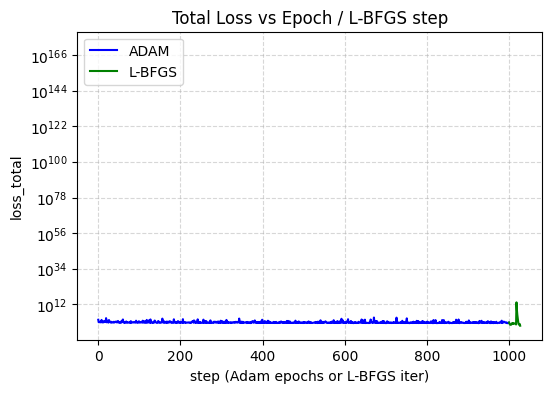

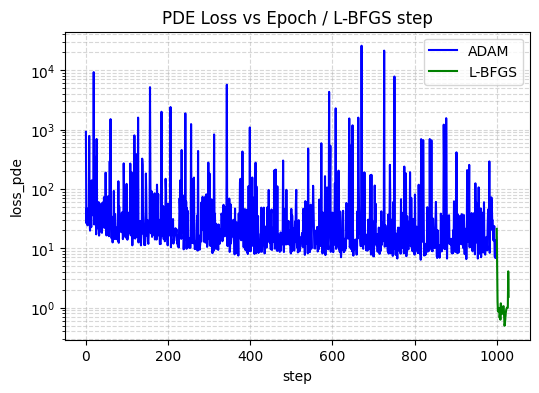

In [23]:
# Plotting three separate loss evolutions
total_history = total_history + lbfgs_total
pde_history   = pde_history + lbfgs_pde

# a) Total Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(n_epochs), total_history[:n_epochs], \
             color = 'blue', label = "ADAM")
plt.semilogy(np.arange(n_epochs, len(total_history)), total_history[n_epochs:], \
             color = 'green', label = "L-BFGS")
plt.title("Total Loss vs Epoch / L-BFGS step")
plt.xlabel("step (Adam epochs or L-BFGS iter)")
plt.ylabel("loss_total")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

# b) PDE Loss
plt.figure(figsize=(6,4))
plt.semilogy(np.arange(n_epochs), pde_history[:n_epochs], \
             color = 'blue', label = "ADAM")
plt.semilogy(np.arange(n_epochs, len(pde_history)), pde_history[n_epochs:], \
             color = 'green', label = "L-BFGS")
plt.title("PDE Loss vs Epoch / L-BFGS step")
plt.xlabel("step")
plt.ylabel("loss_pde")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)

# # c) Data Loss
# plt.figure(figsize=(6,4))
# plt.semilogy(np.arange(n_hom), data_history[:n_hom], \
#              color = 'blue', label = "ADAM with homotopy")
# plt.semilogy(np.arange(n_hom, n_epochs), data_history[n_hom: n_epochs], \
#              color = 'orange', label = "Adam on true PDE")
# plt.semilogy(np.arange(n_epochs, len(pde_history)), data_history[n_epochs:], \
#              color = 'green', label = "L-BFGS on true PDE")
# plt.title("Data Loss vs Epoch / L-BFGS step")
# plt.xlabel("step")
# plt.ylabel("loss_data")
# plt.legend()
# plt.grid(True, which="both", ls="--", alpha=0.5)

plt.show()

## 7.2) Learned Solution vs True Solution

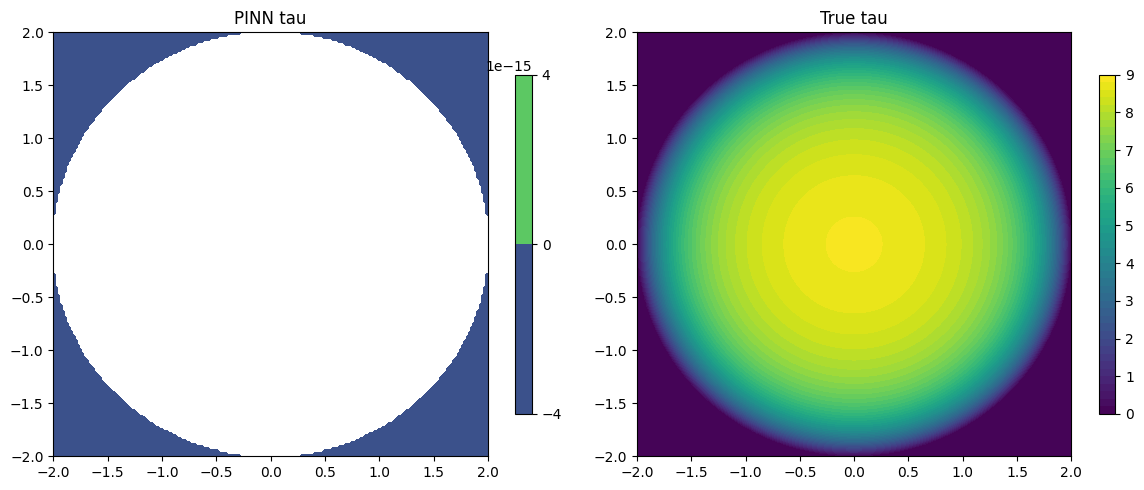

In [24]:
# 9) Visualize PINN vs True tau

n_pts = 200
xx, yy = np.meshgrid(
    np.linspace(-R,R,n_pts),
    np.linspace(-R,R,n_pts)
)
mask = xx**2 + yy**2 <= R**2
pts = np.vstack([xx[mask], yy[mask]]).T

with torch.no_grad():
    inp = torch.from_numpy(pts).to(device)
    pred = model(inp).cpu().numpy().squeeze(-1)

Zp = np.zeros_like(xx); Zt = np.zeros_like(xx)
Zp[mask], Zt[mask] = pred, true_tau_vec(xx[mask], yy[mask])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
cf1 = ax1.contourf(xx, yy, Zp, levels=50, cmap='viridis')
ax1.set_title('PINN tau')
fig.colorbar(cf1, ax=ax1, shrink=0.8)

cf2 = ax2.contourf(xx, yy, Zt, levels=50, cmap='viridis')
ax2.set_title('True tau')
fig.colorbar(cf2, ax=ax2, shrink=0.8)
plt.tight_layout()
plt.show()

## 7.3) Relative error

Global relative L2 error: nan


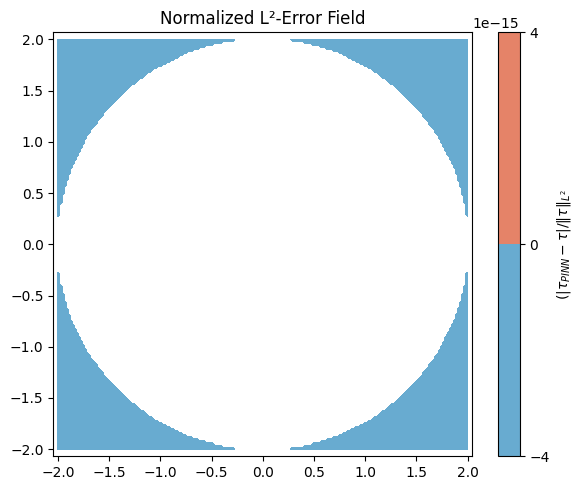

In [25]:
# average relative L2 error
#    ‖tau_pinn − tau_true‖₂ / ‖tau_true‖₂
pred_vals = pred
true_vals = true_tau_vec(pts[:,0], pts[:,1])
tau_l2_norm =  np.linalg.norm(true_vals)
glob_rel_L2 = np.linalg.norm(pred_vals - true_vals) / tau_l2_norm
print(f"Global relative L2 error: {glob_rel_L2:.3e}")

# pointwise relative L2 error
Z_err = np.abs(Zp - Zt)                     # raw error
#Z_err_norm = Z_err / tau_l2_norm
#err_flat = Z_err[mask]              # flatten to disk
#L2_norm = np.sqrt(np.mean(err_flat**2))
#Z_err_norm = np.zeros_like(Z_err)
#Z_err_norm[mask] = Z_err[mask] / L2_norm

plt.figure(figsize=(6,5))
cf = plt.contourf(xx, yy, Z_err, levels=50, cmap='RdBu_r')
plt.colorbar(cf, label=r'$(|\tau_{PINN}-\tau|/\|\tau\|_{L^2}$')
plt.title('Normalized L²‐Error Field')
plt.axis('equal')
plt.tight_layout()
plt.show()